Emigrate
========
Emigrate is an electrophoresis simulator written in python. It is based on the the scipy.integrate.ode solver. It is written with multiple simulation modules to allow varying solution schemes in order to allow easy extension.

First, we'll import emigrate. We'll also import ionize, because it contains the Ion and Solution objects that we will use to set the initial conditions
We'll also import numpy to set up some vectors, and cProfile for code profiling

In [1]:
import emigrate
import ionize

import cProfile
import time

# from matplotlib import pyplot as plot
from matplotlib.pyplot import *
%matplotlib inline

Getting Started
-----------------

### Initial Condition
To define an initial condition, use the emigrate.Electrolyte class. An Electrolyte represents a quasi-1D system of solutions in a channel. It has a set of nodes, and each node represents a point along the axial dimension. Each point has a concentration for each Ion in the system. It can also have other attributes, such as a cross-sectional area, a pH, and an electric field. Only nodes, ions, and concentrations are mandatory. Other attributes are optional.

The easiest way of initializing an electrolyte is to create a set of solutions, and then creating a 

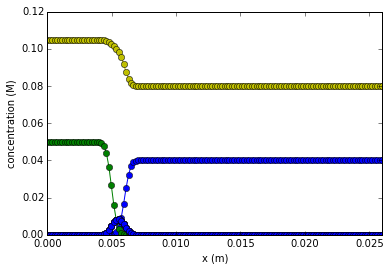

In [2]:
solutions = [ionize.Solution(['hepes', 'tris'], [.05, .105]),
             ionize.Solution(['caproic acid', 'tris', 'fluorescein', 'alexa fluor 488', 'mops', 'acetic acid'], 
                              [.01, .1, .01, .01, .01, .01]),
             ionize.Solution(['hydrochloric acid', 'tris'], [.04, .08]),
            ]

system = emigrate.Frame(dict(
                         n_nodes=137,
                         lengths=[.005, .001, .02],
                         interface_length=.0005,
                         solutions=solutions,
                         current=-500.,
                         ))

# Plot the electrolyte concentrations.
for i in range(len(system.ions)):
    plot(system.nodes, system.concentrations[i,:], '-o')
xlabel('x (m)')
ylabel('concentration (M)')
xlim([min(system.nodes), max(system.nodes)])
show()

### Solving

We solve the solution by using the Migrate class. This class takes the system defined by the Constructor as an input and solves it. 

In [3]:
solver = emigrate.Solver(system, filename='examples/example_1.hdf5', precondition=True, flux_mode='slip')
tmax = 200
dt = 1
ode_solver = 'dopri5'
profile = False

if profile:
    cProfile.run("solver.solve(tmax, dt, method=ode_solver)")
else:
    epoch = time.time()
    solver.solve(tmax, dt, method=ode_solver)
    print 'Solved in {:.2f} seconds.'.format(time.time()-epoch)

Solved in 98.81 seconds.


The solution resides in an Electromigration inside the Migrate object. Here, this object is solver.electromigration. Electromigration objects are iterable, so we can plot each concentration profile from them. In this case, that's somewhat unhelpful since there are so many solutions.

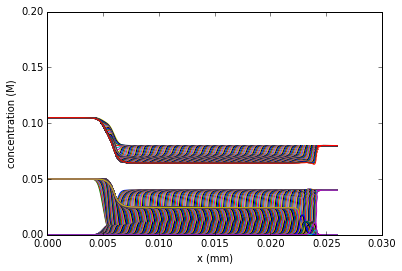

In [4]:
figure()
for frame in solver.frames:
    for ion_concentration in frame.concentrations:
        plot(frame.nodes, ion_concentration, '-')

xlabel('x (mm)')
ylabel('concentration (M)')
ylim([0, .2])
show()

print solver.frames[0]

However, the electromigration essentially acts as a list of frames, so we can also just plot an individual frame.

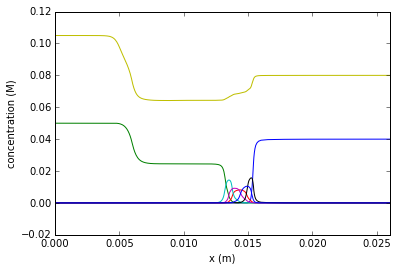

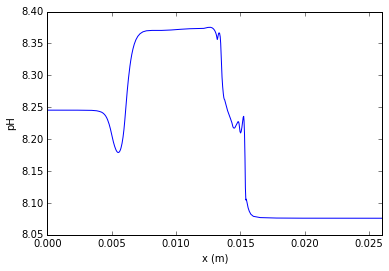

In [5]:
figure()
frame = solver.frames[100]
for ion_concentration in frame.concentrations:
    plot(frame.nodes, ion_concentration, '-')

xlabel('x (m)')
ylabel('concentration (M)')
xlim([min(system.nodes), max(system.nodes)])
show()

figure()
frame = solver.frames[100]
plot(frame.nodes, frame.pH, '-')
xlabel('x (m)')
ylabel('pH')
xlim([min(system.nodes), max(system.nodes)])
show()

Options for solving
-------------------

### Modules
The solver loads two types of modules:
- The flux module.  This module defines the flux of ions through the domain.
- The equilibrium module. This module defines the mobility, diffusivity, and molar conductivity of ions. These values are used by the flux module. 

By default, the flux module called is the compact solver with no adaptive grid.
The equilibrium solver called is the fixed pH solver. 

### Reference Frame
You can set the reference frame of the solution before solving the problem.

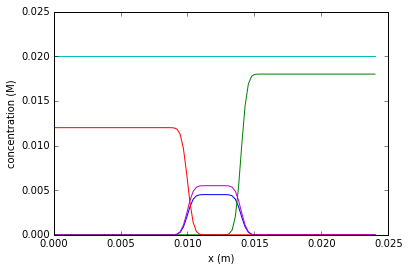

In [6]:
solutions = [ionize.Solution(['acetic acid', 'b-alanine'], [.02, .012]),
             ionize.Solution(['acetic acid', 'pyridine', 'aniline'], [.02, .009/2, .011/2]), 
             ionize.Solution(['acetic acid', 'sodium'], [.02, .018]), 
            ]
system = emigrate.Frame(dict(lengths=[.01, .004, .01],
                         n_nodes=100,
                         interface_length=.0005,
                         solutions=solutions,
                         current_density=500,
                         domain_mode='left', 
                         ))
for i in range(len(system.ions)):
    plot(system.nodes, system.concentrations[i,:])
xlabel('x (m)')
ylabel('concentration (M)')
show()

In [7]:
solver.frames.hdf5.close()
solver = emigrate.Solver(system, filename='examples/example_2.hdf5', precondition=False, flux_mode='slip')
tmax = 80
dt = 1
ode_solver = 'dopri5'
profile = False
solver.set_reference_frame(ionize.load_ion('acetic acid'), 'right')

epoch = time.time()
solver.solve(tmax, dt, method=ode_solver)
print 'Solved in {:.2f} seconds.'.format(time.time()-epoch)

Solved in 101.04 seconds.


emigrate/flux_schemes/SLIP.py:111: RuntimeWarning: invalid value encountered in divide
  cost = deriv / np.nanmax(deriv, 1)[:, np.newaxis]


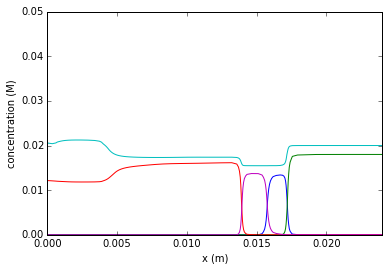

In [8]:
figure()
electrolyte = solver.frames[80]
for ion_concentration in electrolyte.concentrations:
    plot(electrolyte.nodes, ion_concentration, '-')

xlabel('x (m)')
ylabel('concentration (M)')
xlim([min(system.nodes), max(system.nodes)])
ylim([0, .05])
show()

Saving to Disk
--------------
The default method for saving is to write to an HDF5 binary file. If a filename is specified when initializing the Migration, then the each frame will be saved to that HDF5 file as soon as it is computed. We can re-open these HDF5 files and get solutions on demand. 

These HDF5 files can also be opened with the Emigrate application.

In [9]:
# Work with HDF5 file.

If JSON objects are desired, both electromigrations and electrolytes can be written in JSON format. However, beware when doing this for the electromigrations, as the file size can be very large.

In [10]:
# solver.electromigration.write_json('tutorial_example_5.json')

Solutions can then be reloaded using the Electromigration class. Currently, they lose all ion information except name during this process.

In [11]:
# solution_reloaded = emigrate.Electromigration([]).load_json('tutorial_example.json')

# print solution_reloaded.ions
# for t, electrolyte in solution_reloaded.electrolytes.items():
#     for ion_concentration in electrolyte.concentrations:
#             plot(electrolyte.nodes*1000, ion_concentration, '-')
# xlabel('x (mm)')
# ylabel('concentration (M)')
# show()

Instead of saving to file, json objects can simply be generated as text using the "serialize" command, and those objects can be deserialized to return the original object.

Countermigrating Waves
---------------------

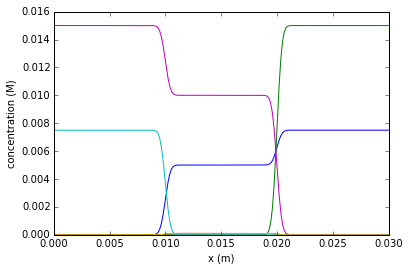

In [12]:
solutions = [ionize.Solution(['caproic acid', 'tris'], [.0075, .015]),
             ionize.Solution(['hydrochloric acid', 'tris', 'alexa fluor 488', 'rhodamine 6g'], 
                             [.005, .01, .0001, .0001]),
             ionize.Solution(['hydrochloric acid', 'bis-tris'], [.0075, .015])
            ]

system = emigrate.Frame(dict(lengths=[0.01]*len(solutions),
                         n_nodes=200,
                         interface_length=.0005,
                         solutions=solutions,
#                          voltage= -50., 
                         current_density=-200,
                         domain_mode='left'
                         ))
for i in range(len(system.ions)):
    plot(system.nodes, system.concentrations[i,:])
xlabel('x (m)')
ylabel('concentration (M)')
show()

In [13]:
# solver.electromigration.hdf5.close()
solver = emigrate.Solver(system, filename='examples/countermigrating.hdf5', precondition=False, flux_mode='slip')
tmax = 100
dt = .1
ode_solver = 'dopri5'
profile = False

if profile:
    cProfile.run("solver.solve(tmax, dt, method=ode_solver)")
else:
    epoch = time.time()
    solver.solve(tmax, dt, method=ode_solver)
    print 'Solved in {} seconds.'.format(time.time()-epoch)

Solved in 142.727826118 seconds.


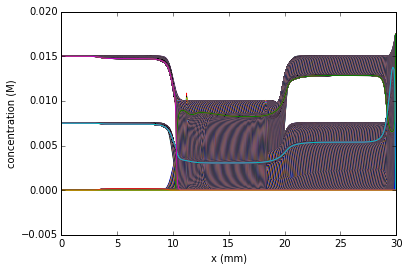

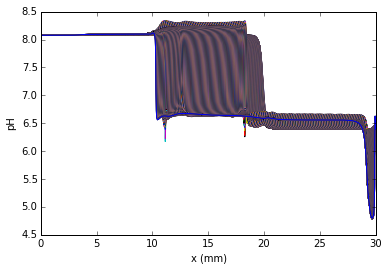

In [14]:
for frame in solver.frames:
        for ion_concentration in frame.concentrations:
            plot(frame.nodes*1000, ion_concentration, '-')
xlabel('x (mm)')
ylabel('concentration (M)')
show()

figure()
for frame in solver.frames:
        plot(frame.nodes*1000, frame.pH, '-')
xlabel('x (mm)')
ylabel('pH')
show()

Example 3
----------

## Non-focusing Example

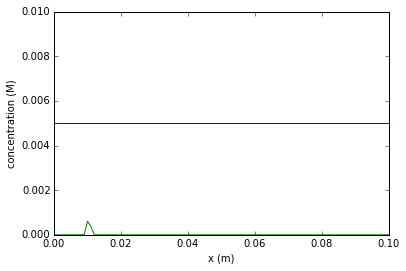

In [15]:
separation_buffer = ionize.Solution(['tris', 'hydrochloric acid'], [.01, .005])
solutions = [separation_buffer,
             separation_buffer + ionize.Solution(['alexa fluor 488'], [.001]), 
             separation_buffer]
system = emigrate.Frame(dict(lengths=[.01, .001, .089],
                         n_nodes=100,
                         interface_length=.0005,
                         solutions=solutions,
                         current_density=-500,
                         domain_mode='left', 
                         ))
for i in range(len(system.ions)):
    plot(system.nodes, system.concentrations[i,:])
xlabel('x (m)')
ylabel('concentration (M)')
show()

In [16]:
solver.frames.hdf5.close()
solver = emigrate.Solver(system, filename='examples/example_4.hdf5', precondition=True, flux_mode='slip')
tmax = 200
dt = 1
ode_solver = 'dopri5'
profile = False
# solver.set_reference_frame(ionize.load_ion('acetic acid'), 'right')

epoch = time.time()
solver.solve(tmax, dt, method=ode_solver)
print 'Solved in {:.2f} seconds.'.format(time.time()-epoch)

Solved in 35.47 seconds.


Example 4
----------

In [17]:
water = ionize.Solution()

solutions = [ionize.Solution(['tris', 'hydrochloric acid'], [.01, .01]),
             ionize.Solution(['hydrochloric acid'], [.01])]
system = emigrate.Frame(dict(lengths=[.01, .01],
                         n_nodes=100,
                         interface_length=.0005,
                         solutions=solutions,
                         current_density=-50,
                         domain_mode='left', 
                         ))
# for i in range(len(system.ions)):
#     plot(system.nodes, system.concentrations[i,:])
# xlabel('x (m)')
# ylabel('concentration (M)')
# show()

In [18]:
solver.frames.hdf5.close()
solver = emigrate.Solver(system, filename='examples/example_5.hdf5', precondition=True, flux_mode='slip')
tmax = 200
dt = 1
ode_solver = 'dopri5'
profile = False
# solver.set_reference_frame(ionize.load_ion('acetic acid'), 'right')

epoch = time.time()
solver.solve(tmax, dt, method=ode_solver)
print 'Solved in {:.2f} seconds.'.format(time.time()-epoch)

Solved in 174.47 seconds.
